In [1]:
from datasets import load_dataset
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vllm import LLM, SamplingParams

/home/gbrun/miniforge3/envs/vllm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 05-06 19:10:39 [__init__.py:207] Automatically detected platform cuda.


2025-05-06 19:10:39,359	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# 10103 for 10,000 actual


ds = load_dataset("lmsys/lmsys-chat-1m", split=f"train[0:1015]")

In [3]:
def chat_len(chat):
    return sum([len(msg['content']) for msg in chat])

inputs = []
sampling_params = []

input_lengths = []
output_lengths = []

for chat in ds['conversation']:
    input_chat = chat[:-1]
    output_chat = chat[-1]

    in_len = chat_len(input_chat)
    out_len = chat_len([output_chat])

    #skip samples that are too long
    if in_len > 10000 or out_len > 10000:
        continue

    inputs.append(input_chat)
    input_lengths.append(in_len)
    output_lengths.append(out_len)

    sampling_params.append(SamplingParams(
                n=1,
                temperature= 1.0,
                top_p=1.0,
                ignore_eos=True,
                max_tokens= max(output_lengths[-1]//4,64),
            ))

In [4]:
len(input_lengths)

1000

/tmp/ipykernel_166918/4102317643.py:4: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(input_lengths), np.log(output_lengths), s =1 )


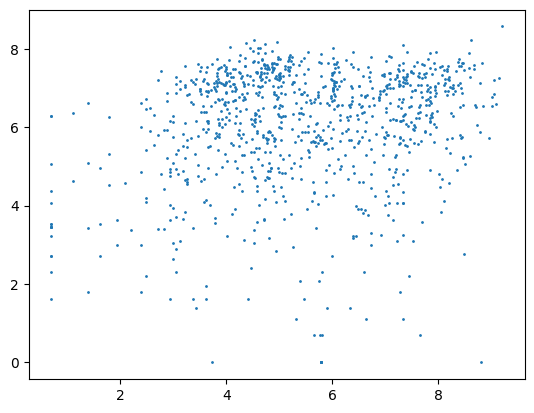

In [5]:
input_lengths = np.array(input_lengths)
output_lengths = np.array(output_lengths)

plt.scatter(np.log(input_lengths), np.log(output_lengths), s =1 )

In [6]:
model_name = 'Qwen/Qwen2.5-14B-Instruct'

In [7]:
import torch
torch._dynamo.config.suppress_errors = True

llm = LLM(
        model=model_name,
        speculative_model=None,
        num_speculative_tokens=None,
        speculative_draft_tensor_parallel_size=None,
        tokenizer=None,
        quantization=None,
        tensor_parallel_size=1,
        pipeline_parallel_size=2,
        trust_remote_code=True,
        dtype='bfloat16',
        # max_model_len=4096 ,
        enforce_eager=True,
        kv_cache_dtype='auto',
        device='cuda',
        block_size=16,
        enable_chunked_prefill=True,
        gpu_memory_utilization=0.90,
        load_format='auto',
        distributed_executor_backend=None,
        enable_prefix_caching=True,
        disable_sliding_window=False,
    )

INFO 05-06 19:10:48 [config.py:575] This model supports multiple tasks: {'score', 'reward', 'generate', 'embed', 'classify'}. Defaulting to 'generate'.
INFO 05-06 19:10:48 [config.py:1485] Defaulting to use mp for distributed inference
INFO 05-06 19:10:48 [config.py:1660] Chunked prefill is enabled with max_num_batched_tokens=2048.
INFO 05-06 19:10:48 [llm_engine.py:235] Initializing a V0 LLM engine (v0.7.4.dev172+gd54990da.d20250302) with config: model='Qwen/Qwen2.5-14B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-14B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=2, disable_custom_all_reduce=False, quantization=None, enforce_eager=True, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend=

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:00<00:00,  7.26it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:01<00:01,  3.47it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:01<00:00,  4.30it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:01<00:00,  3.03it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:02<00:00,  2.33it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:02<00:00,  2.96it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:02<00:00,  3.26it/s]



(VllmWorkerProcess pid=167186) INFO 05-06 19:10:54 [model_runner.py:1117] Loading model weights took 13.7879 GB and 2.865004 seconds
INFO 05-06 19:10:54 [model_runner.py:1117] Loading model weights took 13.7879 GB and 2.778730 seconds
(VllmWorkerProcess pid=167186) INFO 05-06 19:10:55 [worker.py:267] Memory profiling takes 0.63 seconds
(VllmWorkerProcess pid=167186) INFO 05-06 19:10:55 [worker.py:267] the current vLLM instance can use total_gpu_memory (39.38GiB) x gpu_memory_utilization (0.90) = 35.44GiB
INFO 05-06 19:10:55 [worker.py:267] Memory profiling takes 0.68 seconds
INFO 05-06 19:10:55 [worker.py:267] the current vLLM instance can use total_gpu_memory (39.38GiB) x gpu_memory_utilization (0.90) = 35.44GiB
INFO 05-06 19:10:55 [worker.py:267] model weights take 13.79GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 0.24GiB; the rest of the memory reserved for KV Cache is 21.32GiB.
(VllmWorkerProcess pid=167186) INFO 05-06 19:10:55 [executor_base.py:111] # 

In [9]:
# warm_up

results = llm.chat(
    inputs[0:50],
    sampling_params=sampling_params[0:50],
    use_tqdm=True
)

WARNING 05-06 19:11:19 [chat_utils.py:825] Skipping multimodal part (type: 'text') with empty / unparsable content.


NotImplementedError: Pipeline parallelism is only supported through AsyncLLMEngine as performance will be severely degraded otherwise.

In [ ]:
from power_utils import gpuPowerProbe

gpus = 2
interval = 1

inference_powers = []
inference_powers_time = []
power_avgs = []
power_peaks = []
energies = []
power_profiles = []

for id in range(gpus):
    power_profiles.append(gpuPowerProbe(interval=interval, gpu_id=id))
    power_profiles[id].start()

results = llm.chat(
    inputs,
    sampling_params=sampling_params,
    use_tqdm=True
)

for power_profile in power_profiles:
    power, times = power_profile.stop()
    inference_powers.append(power)
    inference_powers_time.append(times)
    power_profile.destroy()

print("\n----------------Power-----------------------")
for id in range(gpus):
    print(f"GPU {id}:")
    power = np.array(inference_powers[id]) / 1000  # to Watt
    times = np.array(inference_powers_time[id])
    avg_power = np.mean(power)
    peak_power = np.max(power)
    energy = np.sum(power*times)

    power_avgs.append(avg_power)
    power_peaks.append(peak_power)
    energies.append(energy)

    print(f"    Power avg : {avg_power :.3f} W")
    print(f"    Power peak: {peak_power :.3f} W")
    print(f"    Energy    : {energy :.3f} J")
    plt.figsize(4,12)
    plt.plot(np.cumsum(inference_powers_time[id]), power, label=f'GPU {id}')

    plt.title("Power consumption")
    plt.legend()
    plt.xlabel(f'Time ({interval} sec intervals)')
    plt.ylabel('Power Consumption (W)')
    plt.savefig('gpu_power_plot.png')

In [ ]:
ttfts = []
latencies = []
latencies_with_queue = []
decode_times = []
queue_times = []

input_tokens = []
output_tokens = []

start = results[0].metrics.first_scheduled_time
end = 0

for resp in results:
    end = max(end, resp.metrics.finished_time)
    # Time to first token (TTFT):
    ttfts.append(resp.metrics.first_token_time - resp.metrics.first_scheduled_time)
    latencies.append(resp.metrics.finished_time - resp.metrics.first_scheduled_time)
    # Total end-to-end latency:
    latencies_with_queue.append(resp.metrics.finished_time - resp.metrics.arrival_time)
    # Decode duration (after first token):
    decode_times.append(resp.metrics.last_token_time - resp.metrics.first_token_time)
    # Queue wait time:
    queue_times.append(resp.metrics.time_in_queue)

    input_tokens.append(len(resp.prompt_token_ids))
    output_tokens.append(len(resp.outputs[0].token_ids))

latency_overall = end - start

tp_overall = (np.sum(input_tokens) + np.sum(output_tokens)) / latency_overall
out_tp_overall = np.sum(output_tokens) / latency_overall
in_tp_overall = np.sum(input_tokens)  / latency_overall

ttfts = np.array(ttfts)
latencies = np.array(latencies)
latencies_with_queue = np.array(latencies_with_queue)
decode_times = np.array(decode_times)
queue_times = np.array(queue_times)

input_tokens = np.array(input_tokens)
output_tokens = np.array(output_tokens)

throughputs = (input_tokens + output_tokens) / decode_times
out_throughputs = (output_tokens) / decode_times

In [ ]:
in_tp_overall, out_tp_overall